In [1]:
import numpy as np
import matplotlib.pyplot as plt
import future.utils

class OpinionEvolution(object):
    def __init__(self, trends, p_o, p_p, kind='probability'):
        
        """
        :param p_o: The model p_o parameter
        :param p_p: The model p_p parameter
        :param trends: The computed simulation trends (status.json in the run folder)
        """
        
        self.kind = kind
        
        self.node2col = {}
        self.nodes2opinions = {}
            
        self.last_it = trends[-1]['iteration'] + 1
        self.last_seen = {}
        
        def transform(w: list, p_o: int, p_p: int):
            w = np.array(w)
            p = w * p_o + (1 - w) * p_p
            p = p.tolist()
            return p

        for it in trends:
            weights = np.array([el for el in it['status'].values()])
            if kind == 'probability':
                sts = transform(weights, p_o, p_p)  # update conditional probabilities of event will occur
            else:
                sts = weights
            its = it['iteration']
            for n, v in enumerate(sts):
                if n in self.nodes2opinions:
                    last_id = self.last_seen[n]
                    last_value = self.nodes2opinions[n][last_id]

                    for i in range(last_id, its):
                        self.nodes2opinions[n][i] = last_value

                    self.nodes2opinions[n][its] = v
                    self.last_seen[n] = its
                else:
                    self.nodes2opinions[n] = [0]*self.last_it
                    self.nodes2opinions[n][its] = v
                    self.last_seen[n] = 0
                    if v < 0.33:
                        self.node2col[n] = '#357db0'
                    elif 0.33 <= v <= 0.66:
                        self.node2col[n] = '#18A558'
                    else:
                        self.node2col[n] = '#ce2626'
    
    def plot(self, filename=None, ax = None):   
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))    
        mx = 0
        for k, l in future.utils.iteritems(self.nodes2opinions):
            if mx < self.last_seen[k]:
                mx = self.last_seen[k]
            x = list(range(0, self.last_seen[k]))
            y = l[0:self.last_seen[k]]
            ax.plot(x, y, lw=1.5, alpha=0.5, color=self.node2col[k])
        plt.xlabel("Iterations")
        plt.ylabel(f"{self.kind.capitalize()}")
        if filename is not None:
            plt.savefig(filename, dpi=300, facecolor='white', bbox_inches='tight')
        else:
            plt.show()
            
        plt.close()

doing 0 lobbyists


Processing:   0%|          | 0/26400 [00:00<?, ?iteration/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x79a30a79b0d0>>
Traceback (most recent call last):
  File "/home/pansanella/mydata/github/almondo-tweets-retrieval/almondo-venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

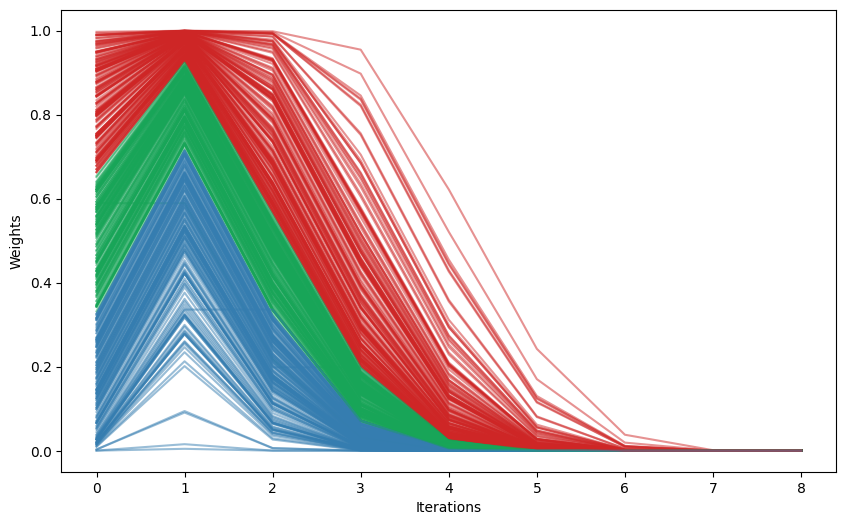

In [ ]:
import json
import os 
from tqdm.notebook import tqdm  # Use tqdm for Jupyter Notebook


values = ['weights', 'probabilities']
NLs = [0, 1, 2, 3, 4, 20]

for nl in NLs:
    print(f'doing {nl} lobbyists')
    
    path = f'../results/balanced_budgets/{nl}_lobbyists/'
    filename = os.path.join(path, 'config.json')
    
    with open(filename, 'r') as f: #qua va messo il path del file initial_config.json
        params = json.load(f)
    
    total_iterations = len(values) * len(params['lambda_values']) * len(params['phi_values']) * params['nruns']
    with tqdm(total=total_iterations, desc="Processing", unit="iteration") as pbar:

        for value in values:
            for _, (lambda_v, phi_v) in enumerate([(l, p) for l in params['lambda_values'] for p in params['phi_values']]):    
                paramspath = os.path.join(path, f'{lambda_v}_{phi_v}/')        
                for run in range(params['nruns']):
                    runpath = os.path.join(paramspath, str(run))
                    if not os.path.exists(runpath+f'/{value}_evolution.png'):
                        with open(runpath+'/status.json', 'r') as f:
                            trends = json.load(f)
                        
                        oe = OpinionEvolution(trends, params['p_o'], params['p_p'], kind=value)
                        oe.plot(runpath+f'/{value}_evolution.png')
                    
                    pbar.update(1)
        
    print(f'finished {nl} lobbyists')